In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install tensorflow

  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cpu


In [6]:
import shutil
import os
 
original_dataset_dir = '/content/drive/MyDrive/Train_segregated'                  # train 
classes_list = os.listdir(original_dataset_dir) 
 
# base_dir = './Split'                              # train-validation
# os.mkdir(base_dir)
 
train_dir = '/content/drive/MyDrive/Train_segregated'      # train data

validation_dir = '/content/drive/MyDrive/Test_segregated'    # validation data


# for cls in classes_list:     
#     os.mkdir(os.path.join(train_dir, cls))
#     os.mkdir(os.path.join(validation_dir, cls))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Train_segregated'

In [ ]:
BATCH_SIZE = 5
EPOCH = 10

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(224),         # crop to 400
        transforms.RandomHorizontalFlip(),  # Horizontal Flip Randomly(p=50)
        transforms.Grayscale(num_output_channels = 1)]),
    
    'val': transforms.Compose([
        transforms.ToTensor(),              
        transforms.CenterCrop(224),         # crop to 400
        transforms.Grayscale(num_output_channels = 1)])
}
 

train_dataset = ImageFolder(root='/content/drive/MyDrive/MURA_subset/train', transform = data_transforms['train'])
val_dataset = ImageFolder(root='/content/drive/MyDrive/MURA_subset/valid', transform = data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         num_workers=4)
val_loader

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 1, 400, 400])
Label = 6 : Fracture image


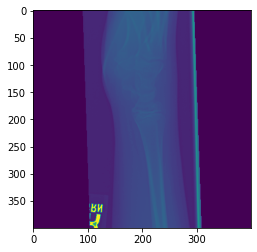

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


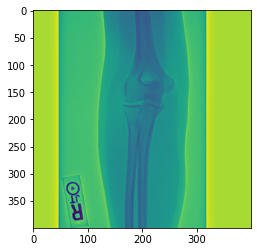

torch.Size([32, 1, 400, 400])
Label = 5 : Fracture image


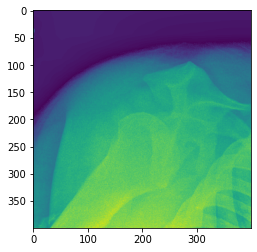

torch.Size([32, 1, 400, 400])
Label = 1 : Fracture image


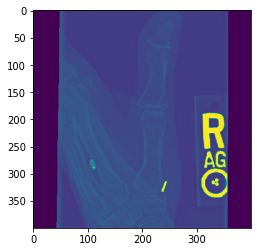

KeyboardInterrupt: ignored

In [ ]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in val_loader:
  
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.numpy()
        l = l.numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

In [ ]:
# Build convolutional neural net
class AlexNet(nn.Module): # AlexNet 모델 설계
    def __init__(self, n_classes = 1):   
        super(AlexNet, self).__init__()

        # 1st conv layer
        self.Conv_1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(96))
        
        # 2nd conv layer
        self.Conv_2 = nn.Sequential(
          nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(256))
        
        # 3rd conv layer
        self.Conv_3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())
        
        # 4th conv layer
        self.Conv_4 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())
        
        # 5th conv layer
        self.Conv_5 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # # 6th conv layer
        # self.Conv_6 = nn.Sequential(
        #   nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # 1st fully connected layer
        self.FC1 = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.8),
          nn.Linear(256*11*11, 4096),
          nn.ReLU())

        # 2nd fully connected layer
        self.FC2 = nn.Sequential(
          nn.Dropout(0.8),
          nn.Linear(4096, 4096),
          nn.ReLU())

        # 3rd fully connected layer --> output layer
        self.FC3 = nn.Sequential(
          nn.Linear(4096, n_classes))
    
    def forward(self, x):   # AlexNet forward propagation
        x = self.Conv_1(x)    
        x = self.Conv_2(x)
        x = self.Conv_3(x)
        x = self.Conv_4(x)
        x = self.Conv_5(x)
        # x = self.Conv_6(x)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.FC3(x)

        return F.log_softmax(x) # softmax 통해 최종 output 계산

model = AlexNet().to(DEVICE)  # 모델 GPU로
model # Print network

AlexNet(
  (Conv_1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv_2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv_3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (Conv_4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (Conv_5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilati

In [ ]:
summary(model, (1, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 98, 98]          11,712
              ReLU-2           [-1, 96, 98, 98]               0
         MaxPool2d-3           [-1, 96, 48, 48]               0
       BatchNorm2d-4           [-1, 96, 48, 48]             192
            Conv2d-5          [-1, 256, 48, 48]         614,656
              ReLU-6          [-1, 256, 48, 48]               0
         MaxPool2d-7          [-1, 256, 23, 23]               0
       BatchNorm2d-8          [-1, 256, 23, 23]             512
            Conv2d-9          [-1, 384, 23, 23]         885,120
             ReLU-10          [-1, 384, 23, 23]               0
           Conv2d-11          [-1, 384, 23, 23]       1,327,488
             ReLU-12          [-1, 384, 23, 23]               0
           Conv2d-13          [-1, 256, 23, 23]         884,992
             ReLU-14          [-1, 256,

<ipython-input-7-c0bcb066ec06>:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # softmax 통해 최종 output 계산


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
def train(model, train_loader, optimizer):
    model.train()                         # 모델 train 상태로
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)  # data, target 값 DEVICE에 할당
        optimizer.zero_grad()                              # optimizer gradient 값 초기화
        output = model(data)
        print(target.shape,output.shape)
        target = target.resize_(output.shape[0],1)
        # print(target.shape,output.shape)
        target = target.type(torch.FloatTensor)
        output = output.type(torch.FloatTensor)
                                       # 할당된 데이터로 output 계산
        loss =  criterion(output, target)                  # Cross Entropy Loss 사용해 loss 계산
        loss.backward()                                    # 계산된 loss back propagation
        optimizer.step()                                   # parameter update

In [ ]:
def evaluate(model, test_loader):
    model.eval()      # 모델 평가 상태로
    test_loss = 0     # test_loss 초기화
    correct = 0       # 맞게 예측한 0 값으로 초기화
    
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)     # data, target DEVICE에 할당
            output = model(data)                                  # output 계산
            test_loss += criterion(output, target).item()         # loss 계산(총 loss 에 더해주기)
            pred = output.max(1, keepdim=True)[1]                 # 계산된 벡터값 중 가장 큰 값 가지는 class 예측
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset)                         # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset)     # test(validation) 데이터 정확도
    return test_loss, test_accuracy

In [ ]:
import time
import copy
 
def train_model(model ,train_loader, val_loader, optimizer, num_epochs = 1):
    acc_t = []; acc_v = []    # train, validation accuracy 저장할 list
    loss_t = []; loss_v = []  # train, validation loss 저장할 list

    best_acc = 0.0  # beset accuracy 초기화
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time() 
        print(epoch)                                    # 학습 시간 계산
        train(model, train_loader, optimizer)
        
                           # train 데이터로 학습
        train_loss, train_acc = evaluate(model, train_loader)   # train_loss, train_acc 계산
        val_loss, val_acc = evaluate(model, val_loader)         # valid_loss, valid_acc 계산
        
        if val_acc>best_acc:  # update best accuracy
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())  # 가장 accuracy 높은 model 저장
        
        # loss, accuarcy 저장하기
        acc_t.append(train_acc); acc_v.append(val_acc)
        loss_t.append(train_loss);loss_v.append(val_loss)

        #학습 결과 및 시간 출력
        time_elapsed = time.time() - since 
        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print() 

    # Accuracy Graph
    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    # Loss Graph
    plt.plot(range(len(loss_t)), loss_t, 'b', range(len(loss_v)), loss_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Loss')
    red_patch = mpatches.Patch(color='red', label='Validation Loss')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    model.load_state_dict(best_model_wts) # validation accuracy, 가장 높은 모델 저장
    return model

In [ ]:
# weight decay = 1e-4
model = train_model(model ,train_loader, val_loader, optimizer, 5)

1


<ipython-input-7-c0bcb066ec06>:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # softmax 통해 최종 output 계산


torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torch.Size([5, 1])
torch.Size([5]) torc

IndexError: ignored

In [2]:
#importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
from skimage.io import imshow
from pathlib import Path
import pandas as pd

# Input data files are available in the "../mura_unzipped/" directory.
# Running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("D:/codes/GAIP-NUS/MURA-v1.1/MURA-2"))

['train', 'train_image_paths.csv', 'train_labeled_studies.csv', 'valid', 'valid_image_paths.csv', 'valid_labeled_studies.csv']


In [8]:
pip install skimage

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [3 lines of output]
  
  *** Please install the `scikit-image` package (instead of `skimage`) ***
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
dataset_root = Path('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2')

In [4]:
list(dataset_root.iterdir())

[WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train_image_paths.csv'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train_labeled_studies.csv'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid_image_paths.csv'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid_labeled_studies.csv')]

In [5]:
#df is the generated dataframe whose head can be visualized below
df = pd.read_csv('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train_image_paths.csv', header=None, names=['filename'])
df.head()

,filename
0,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...
1,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...
2,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...
3,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...
4,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...


In [6]:
#Adding class column to the dataframe with positive or negative label
#Classification is done on basis of the image names (postive/negative)
df['class'] = (df.filename.str.extract('study.*_(positive|negative)'))
df.head()

,filename,class
0,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...,positive
1,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...,positive
2,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...,positive
3,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...,positive
4,D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train/XR_SH...,positive


In [7]:
#A function to generate the dataframe for a csv file
def generate_df(csv_name):
    df = pd.read_csv(csv_name, header=None, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    return df

In [8]:
list(dataset_root.iterdir())

[WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train_image_paths.csv'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train_labeled_studies.csv'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid_image_paths.csv'),
 WindowsPath('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid_labeled_studies.csv')]

In [9]:
#Dividing the image data generated into train set and validation set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)
#Creating training set
train_gen = datagen.flow_from_dataframe(generate_df('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        target_size=(224, 224),
                                        class_mode='binary')
#Creating validation set
valid_gen = datagen.flow_from_dataframe(generate_df('D:/codes/GAIP-NUS/MURA-v1.1/MURA-2/valid_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        target_size=(224, 224),
                                        class_mode='binary')

Found 23237 validated image filenames belonging to 2 classes.
Found 1683 validated image filenames belonging to 2 classes.


In [10]:
#Downloading the densenet model pretrained on the imagenet dataset
densenet = tf.keras.applications.DenseNet169(weights='imagenet', include_top = False, input_shape=(224, 224, 3))


In [11]:
#Freezing the weights of the pretrained model
densenet.trainable = False

In [12]:
#Adding the Flatten layer and the sigmoid classification layer to the pretrained densenet model
model = tf.keras.models.Sequential([
    densenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 1)                 81537     
                                                                 
Total params: 12,724,417
Trainable params: 81,537
Non-trainable params: 12,642,880
_________________________________________________________________


In [14]:
#Compiling the model using adam optimizer
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [15]:
#Fitting the model on training test
history = model.fit_generator(train_gen, epochs=15, validation_data=valid_gen, use_multiprocessing=False)

C:\Users\tanay\AppData\Local\Temp\ipykernel_8244\3510587823.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=15, validation_data=valid_gen, use_multiprocessing=False)


Epoch 1/15
727/727 [==============================] - 1315s 2s/step - loss: 1.1885 - accuracy: 0.6756 - val_loss: 1.1450 - val_accuracy: 0.6797
Epoch 2/15
727/727 [==============================] - 1355s 2s/step - loss: 1.0434 - accuracy: 0.7332 - val_loss: 1.2022 - val_accuracy: 0.6982
Epoch 3/15
727/727 [==============================] - 1472s 2s/step - loss: 0.9414 - accuracy: 0.7602 - val_loss: 1.3255 - val_accuracy: 0.6815
Epoch 4/15
727/727 [==============================] - 1561s 2s/step - loss: 0.9148 - accuracy: 0.7807 - val_loss: 1.7020 - val_accuracy: 0.6696
Epoch 5/15
727/727 [==============================] - 1441s 2s/step - loss: 0.8207 - accuracy: 0.7918 - val_loss: 1.5352 - val_accuracy: 0.6815
Epoch 6/15
727/727 [==============================] - 1401s 2s/step - loss: 0.7029 - accuracy: 0.8115 - val_loss: 1.5380 - val_accuracy: 0.6720
Epoch 7/15
727/727 [==============================] - 1446s 2s/step - loss: 0.6977 - accuracy: 0.8195 - val_loss: 1.7449 - val_accuracy:

In [16]:
#Saving the model weights
model.save("bonemodel.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
# Loading the saved model

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
model_new = load_model('bonemodel.h5')
model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 1)                 81537     
                                                                 
Total params: 12,724,417
Trainable params: 81,537
Non-trainable params: 12,642,880
_________________________________________________________________


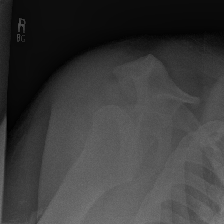

In [18]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

img = tf.keras.utils.load_img("D:/codes/GAIP-NUS/image1.png", target_size=(224,224))
img

In [19]:
#convert image to array
input_img = tf.keras.utils.img_to_array(img)
input_img = np.expand_dims(input_img, axis=0)
input_img

array([[[[ 54.,  54.,  54.],
         [ 42.,  42.,  42.],
         [ 43.,  43.,  43.],
         ...,
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.]],

        [[ 42.,  42.,  42.],
         [ 38.,  38.,  38.],
         [ 41.,  41.,  41.],
         ...,
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.]],

        [[ 41.,  41.,  41.],
         [ 35.,  35.,  35.],
         [ 38.,  38.,  38.],
         ...,
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.]],

        ...,

        [[ 99.,  99.,  99.],
         [ 77.,  77.,  77.],
         [ 63.,  63.,  63.],
         ...,
         [116., 116., 116.],
         [114., 114., 114.],
         [120., 120., 120.]],

        [[103., 103., 103.],
         [ 78.,  78.,  78.],
         [ 64.,  64.,  64.],
         ...,
         [123., 123., 123.],
         [122., 122., 122.],
         [124., 124., 124.]],

        [[ 95.,  95.,  95.],
       

In [20]:
class_arr = ["No Fracture", "Fracture"]

#Predict the inputs on the model

predict_img = model.predict(input_img)
predict_img

max_value = max(list(predict_img))
a = list(max_value)
a
index = a.index(max_value)
print(class_arr[index])

1/1 [==============================] - 2s 2s/step
No Fracture


In [22]:
test_acc = model.evaluate(valid_gen)
print("The testing accuracy is: ", test_acc[1]*100, "%")

53/53 [==============================] - 95s 2s/step - loss: 2.1638 - accuracy: 0.6803
The testing accuracy is:  68.03327202796936 %


In [ ]:
df = pd.DataFrame(history.history)
df = df.astype(float)
df.plot()

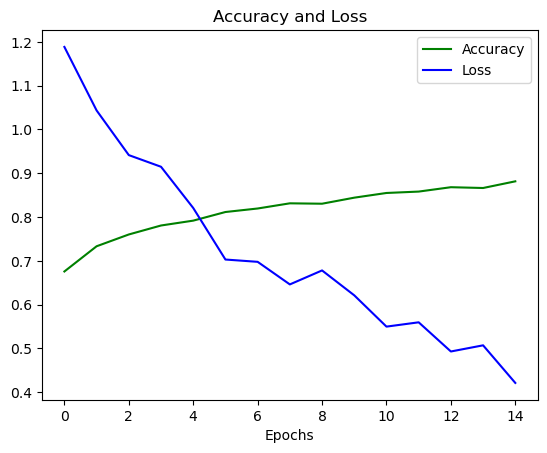

In [40]:
loss_train = history.history['accuracy']
loss_val = history.history['loss']
epochs = range(0,15)
plt.plot(epochs, loss_train, 'g', label='Accuracy')
plt.plot(epochs, loss_val, 'b', label='Loss')
plt.title('Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()
plt.show()

In [2]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
model_new = load_model('bonemodel.h5')
model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 1)                 81537     
                                                                 
Total params: 12,724,417
Trainable params: 81,537
Non-trainable params: 12,642,880
_________________________________________________________________


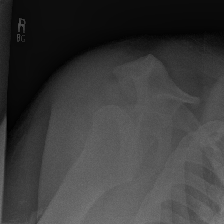

In [6]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
from skimage.io import imshow
from pathlib import Path
import pandas as pd

img = tf.keras.utils.load_img("D:/codes/GAIP-NUS/image1.png", target_size=(224,224))
img

In [7]:
#convert image to array
input_img = tf.keras.utils.img_to_array(img)
input_img = np.expand_dims(input_img, axis=0)
input_img

array([[[[ 54.,  54.,  54.],
         [ 42.,  42.,  42.],
         [ 43.,  43.,  43.],
         ...,
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.]],

        [[ 42.,  42.,  42.],
         [ 38.,  38.,  38.],
         [ 41.,  41.,  41.],
         ...,
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.]],

        [[ 41.,  41.,  41.],
         [ 35.,  35.,  35.],
         [ 38.,  38.,  38.],
         ...,
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.],
         [ 11.,  11.,  11.]],

        ...,

        [[ 99.,  99.,  99.],
         [ 77.,  77.,  77.],
         [ 63.,  63.,  63.],
         ...,
         [116., 116., 116.],
         [114., 114., 114.],
         [120., 120., 120.]],

        [[103., 103., 103.],
         [ 78.,  78.,  78.],
         [ 64.,  64.,  64.],
         ...,
         [123., 123., 123.],
         [122., 122., 122.],
         [124., 124., 124.]],

        [[ 95.,  95.,  95.],
       

In [9]:
class_arr = ["No Fracture", "Fracture"]

#Predict the inputs on the model

predict_img = model_new.predict(input_img)
predict_img

max_value = max(list(predict_img))
a = list(max_value)
a
index = a.index(max_value)
print(class_arr[index])

1/1 [==============================] - 2s 2s/step
No Fracture
